In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv


Reference: https://www.kaggle.com/robikscube/time-series-forecasting-with-prophet

In [3]:
df_pjm=pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv',index_col=[0],parse_dates=[0])
df_pjm.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
df_pjm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [5]:
print(df_pjm.isnull().sum())

PJME_MW    0
dtype: int64


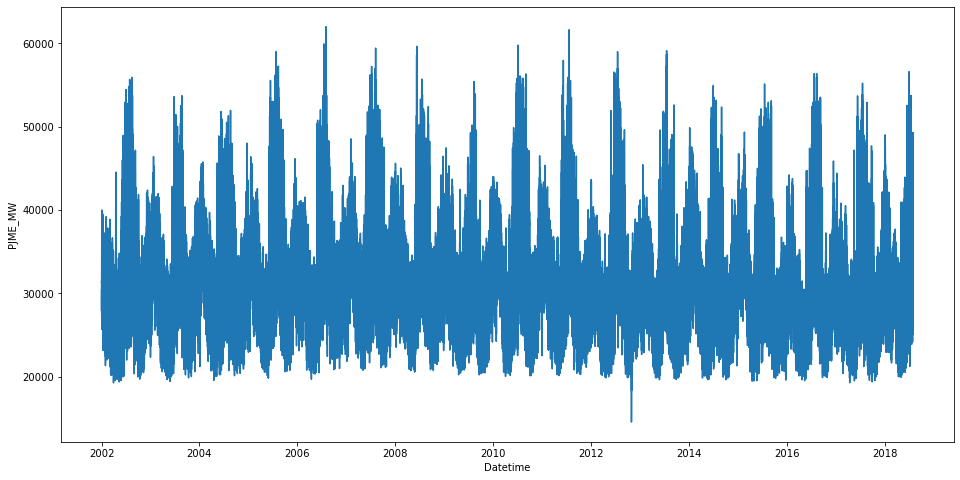

In [6]:
data=df_pjm
plt.figure(figsize=(16,8))
sns.lineplot(data.index,'PJME_MW',data=data)

In [7]:
def create_feature(df,label=None):
    df=df.copy()
    df['date']=df.index
    df['hour']=df['date'].dt.hour
    df['dayofweek']=df['date'].dt.dayofweek
    df['quarter']=df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
        
    if label:
        y=df[label]
        return X,y
    return X

X,y=create_feature(data,label='PJME_MW')

X.tail()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2018-01-01 20:00:00,20,0,1,1,2018,1,1,1
2018-01-01 21:00:00,21,0,1,1,2018,1,1,1
2018-01-01 22:00:00,22,0,1,1,2018,1,1,1
2018-01-01 23:00:00,23,0,1,1,2018,1,1,1
2018-01-02 00:00:00,0,1,1,1,2018,2,2,1


In [8]:
trainData=pd.concat([X,y],axis=1)
trainData.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


In [ ]:
sns.pairplot(trainData,hue='hour',x_vars=['hour','dayofweek','year','month'],y_vars='PJME_MW')

In [ ]:
split_date = '01-Jan-2015'
pjme_train = data.loc[data.index <= split_date].copy()
pjme_test=data.loc[data.index>split_date].copy()

pjme_train.reset_index().rename(columns={'Datetime':'ds','PJME_MW':'y'}).head()
#df['ds']=pjme_train['Datetime'].copy()

**Prophet Model**

This model is used for Timeseries data and univariate datasets. Based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data.

In [ ]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

model=Prophet()
model.fit(pjme_train.reset_index().rename(columns={'Datetime':'ds','PJME_MW':'y'}))

In [ ]:
Prediction=model.predict(pjme_test.reset_index().rename(columns={'Datetime':'ds','PJME_MW':'y'}))

Prediction.head()

In [ ]:
model.plot(Prediction)

In [ ]:
mean_absolute_error(pjme_test['PJME_MW'],Prediction['yhat'])